# 1. Trabajo Práctico N°2: de Analisis + Curación

# Trabajo Práctico N°2: Análisis Exploratorio y Curación de Datos

## Introducción

Este trabajo práctico intenta continúa la exploración de los datasets planteados en el [primer trabajo práctico](https://github.com/luisdvlpr/diplodatos2021-datasets/blob/main/TP1_Analisis_y_Visualizacion/enunciado_tp1_analisis_y_visualizacion.ipynb)

En el primer práctico pudimos notar algunas características propias de las series temporales y en particular del dominio del comportamiento de un ecommerce genérico. Muchas de ellas son __series no estacionarias__, ya que la caracterización de estas distribuciones ( media, varianza ) cambian a través del tiempo y se observan ademas alguna tendencias. __Por otra parte se se distinguen patrones de estacionalidad, por ej. semanal__. 

Lo anterior trae __consecuencias__ directas en la selección de las metodologías adecuadas para abordar las problemáticas de tratamiento de __valores faltantes__, detección de __outliers__ y la construcción de __modelos predictivos__.

Por otra parte, debe notarse que el tamaño de las economías de cada pais y la adopción de los hábitos de uso de estas plataformas en cada uno de ellos hace que el uso de cantidad de sesiones no sea una medida adecuada para compararles. Entonces, el análisis de estas series se centra por lo general en el cambio porcentual de los precios en vez del cambio en los valores absolutos. Esto resulta en que en vez de modelar los índices originales, previamente se habitúa realizar una __transformación logarítmica__ o trabajar con la __tasa de conversión__ a fin de expresarlos en un __único métrica que les caracterice__ para evitar distorsiones debidas a los tamaños de sus economías y hábitos de uso.

### Carga del dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
 
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# some config
plt.rcParams['figure.figsize'] = (12, 9)
pd.options.display.float_format = '{:20,.2f}'.format #configuración para sacar la notación cientifica

In [3]:
#cambie parse_dates=True, por la columna especifica de fecha para que aplique el tipo de formato e indexe por fecha
data_orig = pd.read_csv(
    'datasets/traffic_AR_CL_UY.csv', 
    usecols = ["Fecha", "flow", "Site", "Device", "Loading", "Shipping", "Payments", "Review", "Congrats"], 
    parse_dates=["Fecha"],index_col=["Fecha"]
)
traffic_data=data_orig.copy()

In [4]:
#filtramos los datos para trabajar solo con MLA, flujo directo, desktop y android

traffic_data = traffic_data[traffic_data.Site==("MLA")]
traffic_data = traffic_data[traffic_data.flow==("direct")]
traffic_data = traffic_data[(traffic_data.Device==("Android"))|(traffic_data.Device==("Desktop"))]
traffic_data_D = traffic_data[traffic_data.Device==("Desktop")]
traffic_data_A = traffic_data[traffic_data.Device==("Android")]

In [5]:
#agregamos columnas relativas a las fechas

df_traffic=traffic_data.copy()
df_traffic["Weekday"] = traffic_data.index.day_name()
df_traffic["Month"] = traffic_data.index.month_name()
df_traffic["Year"] = traffic_data.index.year
new = df_traffic["Month"].copy().astype(str)
new1 = df_traffic["Year"].copy().astype(str)
df_traffic["Months"]= new.str.cat(new1, sep ="-")

In [6]:
#agregamos columnas relativas a las tasas de conversión entre las diferentes etapas de compra
df_traffic["Shipping-Payments"] = df_traffic["Payments"] / df_traffic["Shipping"]
df_traffic["Payments-Review"] = df_traffic["Review"] / df_traffic["Payments"]
df_traffic["Review-Congrats"] = df_traffic["Congrats"] / df_traffic["Review"]
df_traffic["Shipping-Congrats"] = df_traffic["Congrats"] / df_traffic["Shipping"]

#agrupamos las columnas según sean etapas de compra o índices para evaluar su comportamiento por separado
cols_indices = ['Shipping-Payments', 'Payments-Review', 'Review-Congrats', 'Shipping-Congrats']
cols_etapas = ['Shipping', 'Payments', 'Review', 'Congrats']

# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic_desktop = df_traffic[df_traffic.Device==("Desktop")]
df_traffic_android = df_traffic[df_traffic.Device==("Android")]

***DATOS FALTANTES***

In [7]:
#buscamos si hay datos faltantes.. se puede buscar con .isna() o con .isnull()
cols_na = traffic_data.isna().sum()
cols_na[cols_na> 0]

Shipping    1
Review      2
dtype: int64

In [8]:
#buscamos si hay datos faltantes.. se puede buscar con .isna() o con .isnull()
traffic_data.drop('Device', 1).isna().groupby(traffic_data.Device, sort=False).sum()

,flow,Site,Loading,Shipping,Payments,Review,Congrats
Device,,,,,,,
Android,0,0,0,1,0,2,0
Desktop,0,0,0,0,0,0,0


Podemos identificar que los 3 datos faltantes corresponden a los devices Android.

<AxesSubplot:>

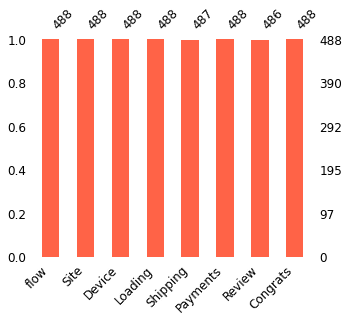

In [9]:
#importamos la libreria missingno y visualizamos que son las dos columnas previamente identificadas las que no contienen los 7708 datos.
import missingno as msno
msno.bar(traffic_data_A,figsize=(5, 4), fontsize=12, color="tomato")

<AxesSubplot:>

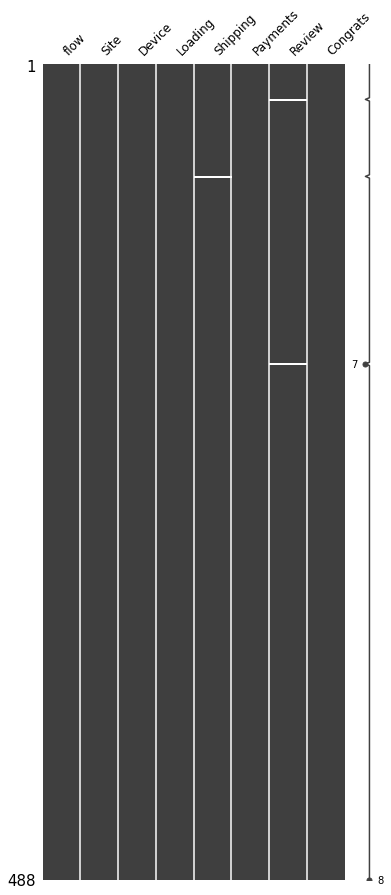

In [10]:
#podemos chequear que no se corresponden los datos faltantes de una columna con la de la otra.
msno.matrix(traffic_data_A,figsize=(6,15), fontsize=12)

***DATOS NULOS***

In [11]:
#buscamos los datos nulos e identificamos en qué columnas se encuentran..
cols_null_D = df_traffic_desktop[df_traffic_desktop == 0].count(axis=0)
cols_null_D[cols_null_D > 0]

Loading     2
Shipping    2
Payments    2
Review      2
Congrats    2
dtype: int64

In [12]:
cols_null_A = df_traffic_android[df_traffic_android == 0].count(axis=0)
cols_null_A[cols_null_A > 0]

Loading     2
Shipping    2
Payments    2
Review      2
Congrats    2
dtype: int64

In [13]:
df_traffic_android_null = df_traffic_android.loc[df_traffic_android.Shipping<1]
df_traffic_android_null

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-12-05,direct,MLA,Android,0,0.00,0,0.00,0,Thursday,December,2019,December-2019,nan,nan,nan,nan
2019-12-06,direct,MLA,Android,0,0.00,0,0.00,0,Friday,December,2019,December-2019,nan,nan,nan,nan


In [14]:
df_traffic_android_nan = df_traffic_android[(df_traffic_android["Review"].isna())|(df_traffic_android["Shipping"].isna())]
df_traffic_android_nan

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-03-22,direct,MLA,Android,179146,"169,846.00",138177,nan,89890,Friday,March,2019,March-2019,0.81,nan,nan,0.53
2019-05-07,direct,MLA,Android,224056,nan,172472,"121,321.00",113250,Tuesday,May,2019,May-2019,nan,0.70,0.93,nan
2019-08-27,direct,MLA,Android,236701,"223,993.00",180928,nan,113464,Tuesday,August,2019,August-2019,0.81,nan,nan,0.51


In [15]:
df_traffic_desktop_null = df_traffic_desktop.loc[df_traffic_desktop.Shipping<1]
df_traffic_desktop_null

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-12-05,direct,MLA,Desktop,0,0.00,0,0.00,0,Thursday,December,2019,December-2019,nan,nan,nan,nan
2019-12-06,direct,MLA,Desktop,0,0.00,0,0.00,0,Friday,December,2019,December-2019,nan,nan,nan,nan


In [16]:
df_traffic_ceros_nan = df_traffic.replace(['0', 0], np.nan)

In [17]:
dates_null= df_traffic_desktop_null.index
dates_null

DatetimeIndex(['2019-12-05', '2019-12-06'], dtype='datetime64[ns]', name='Fecha', freq=None)

Encontramos que los dos valores nulos de cada columna se corresponden a los mismos días: 5 y 6 de Diciembre de 2019. Dos días consecutivos.

Text(0.5, 1.0, 'Etapas-DESKTOP')

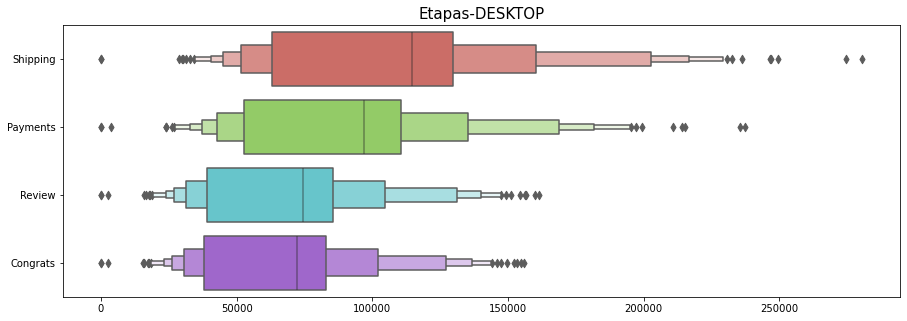

In [18]:
#df_traffic_desktop[cols_etapas].plot( marker='.', alpha=0.5, linestyle='-', figsize=(20, 10)).set_title("DESKTOP")
plt.rcParams['figure.figsize'] = (15, 5)
sns.boxenplot(data=df_traffic_desktop[cols_etapas], orient="h", palette='hls')
plt.title('Etapas-DESKTOP', size=15)


Text(0.5, 1.0, 'Etapas-ANDROID')

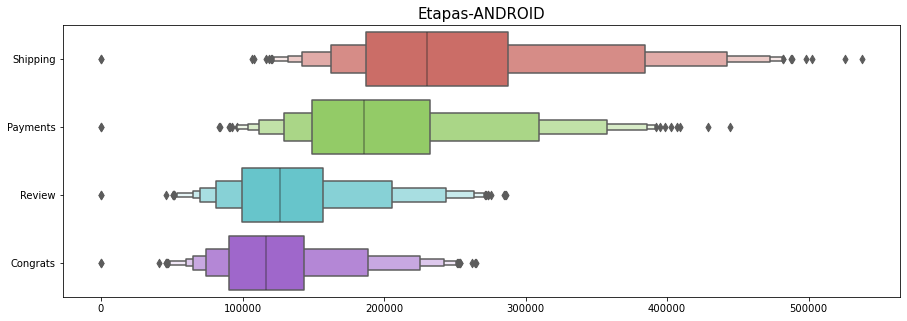

In [19]:
sns.boxenplot(data=df_traffic_android[cols_etapas], orient="h", palette='hls')
plt.title('Etapas-ANDROID', size=15)


Text(0.5, 1.0, 'Indices-DESKTOP')

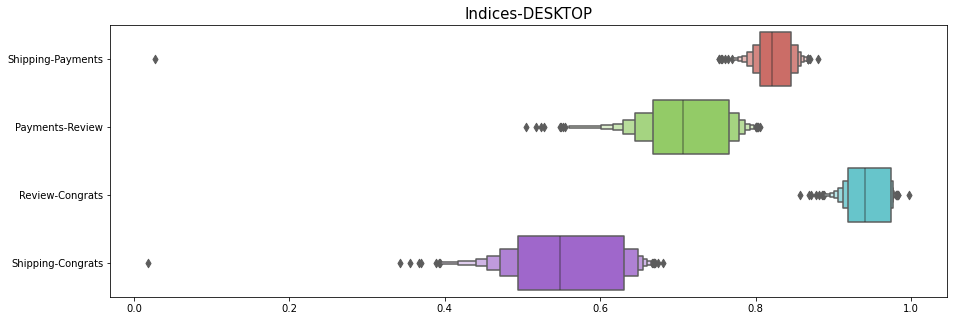

In [20]:
sns.boxenplot(data=df_traffic[cols_indices], orient="h", palette='hls')
plt.title('Indices-DESKTOP', size=15)

Text(0.5, 1.0, 'Indices-ANDROID')

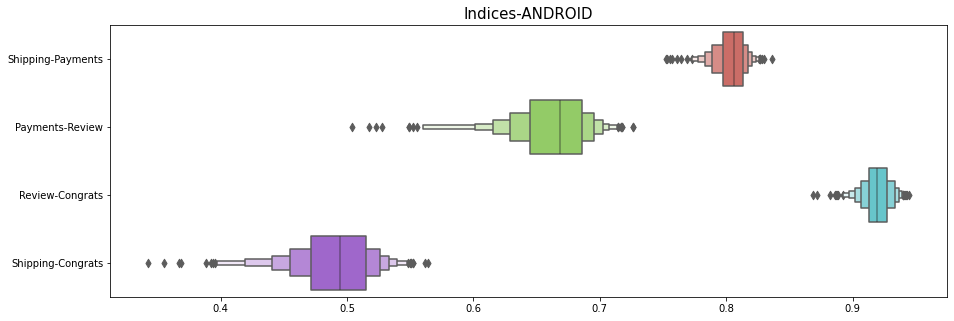

In [21]:
sns.boxenplot(data=df_traffic_android[cols_indices], orient="h", palette='hls')
plt.title('Indices-ANDROID', size=15)

Text(0.5, 1.0, 'DESKTOP-Indices')

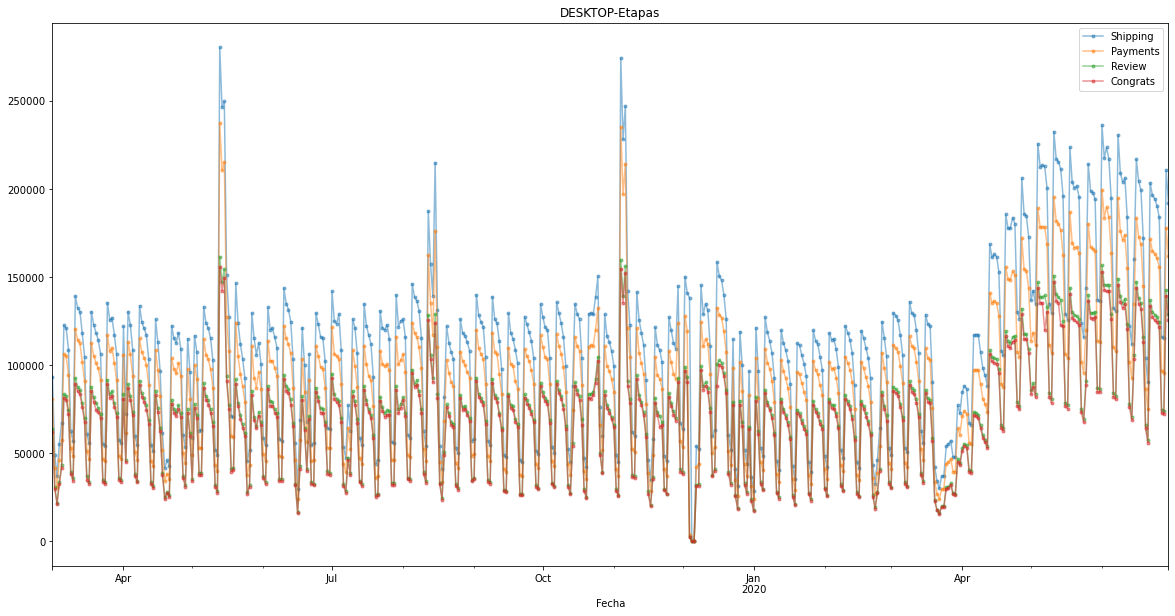

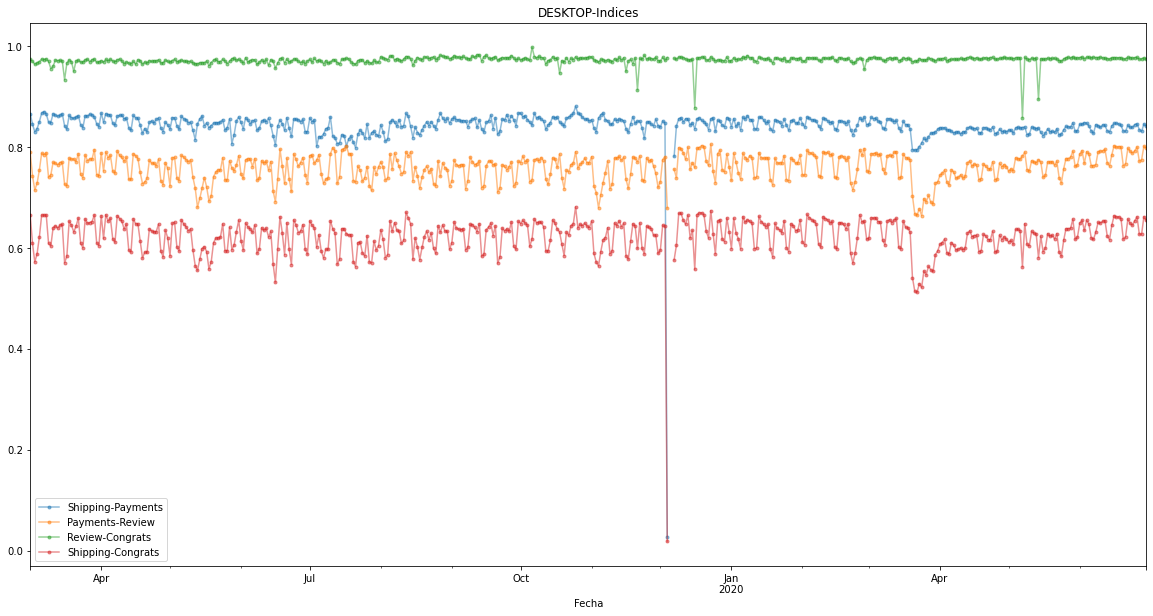

In [22]:
df_traffic_desktop[cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("DESKTOP-Etapas")
df_traffic_desktop[cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("DESKTOP-Indices")

Text(0.5, 1.0, 'ANDROID-Indices')

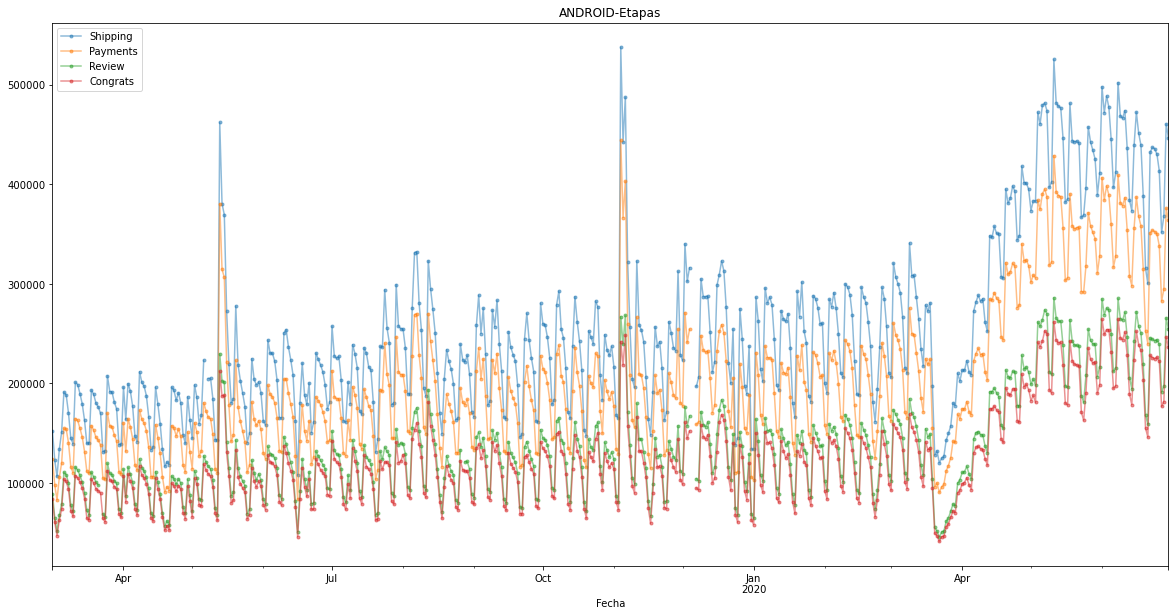

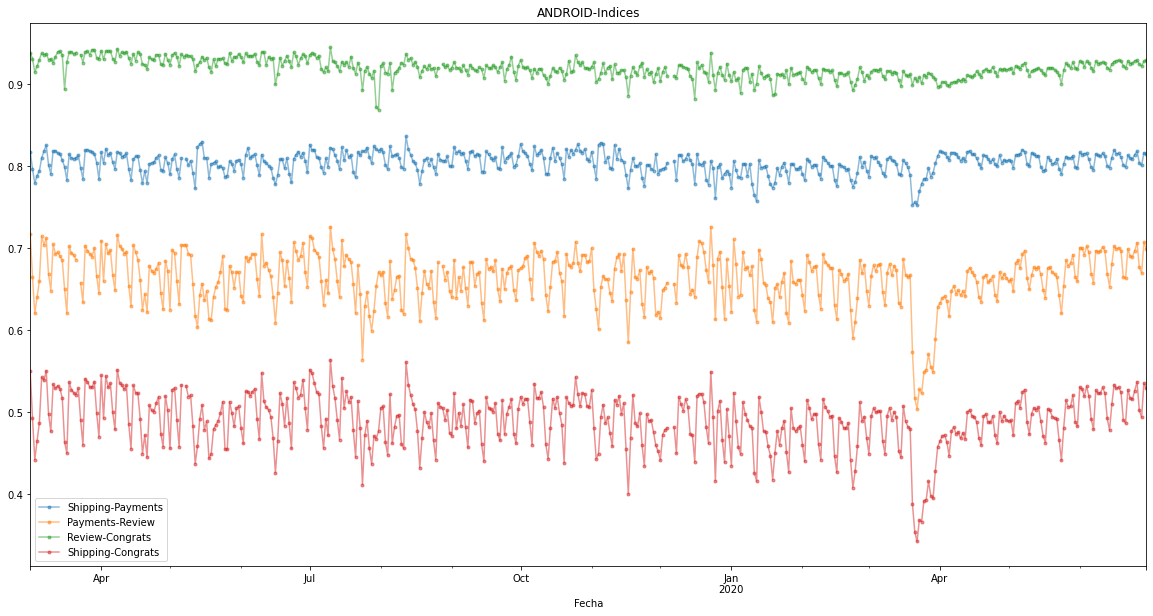

In [55]:
df_traffic_android[cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID-Etapas")
df_traffic_android[cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID-Indices")

In [23]:
df_traffic_desktop[cols_indices].describe()

,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
count,486.00,486.00,486.00,486.00
mean,0.84,0.76,0.97,0.62
std,0.04,0.03,0.01,0.04
min,0.03,0.66,0.86,0.02
25%,0.84,0.74,0.97,0.60
50%,0.85,0.77,0.97,0.63
75%,0.85,0.78,0.98,0.65
max,0.88,0.81,1.00,0.68


In [24]:
#analizamos los valores mínimos de cada índice que representan el 1% del total de los datos 
#el 1% de cada índice representa a 5 valores. Juntando los de cada índice podemos ver que al ser el total 12, cuando deberian ser 20 por lo que hay 8 casos que comparten fecha.
df_traffic_android_1ind= df_traffic_desktop[(df_traffic_desktop["Shipping-Payments"]<df_traffic_desktop["Shipping-Payments"].quantile(0.01))|(df_traffic_desktop["Payments-Review"]<df_traffic_desktop["Payments-Review"].quantile(0.01))|(df_traffic_desktop["Review-Congrats"]<df_traffic_desktop["Review-Congrats"].quantile(0.01))|(df_traffic_desktop["Shipping-Congrats"]<df_traffic_desktop["Shipping-Congrats"].quantile(0.01))]
df_traffic_android_1ind.shape

(12, 16)

In [25]:
df_traffic_android_1ind= df_traffic_android[(df_traffic_android["Shipping-Payments"]<df_traffic_android["Shipping-Payments"].quantile(0.01))|(df_traffic_android["Payments-Review"]<df_traffic_android["Payments-Review"].quantile(0.01))|(df_traffic_android["Review-Congrats"]<df_traffic_android["Review-Congrats"].quantile(0.01))|(df_traffic_android["Shipping-Congrats"]<df_traffic_android["Shipping-Congrats"].quantile(0.01))]
dates_min_ind_A=df_traffic_android_1ind.index

In [26]:
dates_min_ind_D = df_traffic_android_1ind.index

In [27]:
df_traffic_android_1ind

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-07-30,direct,MLA,Android,270806,"257,466.00",211239,"138,218.00",120481,Tuesday,July,2019,July-2019,0.82,0.65,0.87,0.47
2019-07-31,direct,MLA,Android,267888,"255,094.00",208843,"140,058.00",121685,Wednesday,July,2019,July-2019,0.82,0.67,0.87,0.48
2019-11-17,direct,MLA,Android,154659,"148,548.00",114814,"67,206.00",59542,Sunday,November,2019,November-2019,0.77,0.59,0.89,0.40
2019-12-16,direct,MLA,Android,300337,"298,794.00",232502,"149,014.00",131459,Monday,December,2019,December-2019,0.78,0.64,0.88,0.44
2019-12-25,direct,MLA,Android,152193,"145,656.00",110854,"67,975.00",60694,Wednesday,December,2019,December-2019,0.76,0.61,0.89,0.42
2020-01-12,direct,MLA,Android,202894,"193,222.00",146323,"89,357.00",80449,Sunday,January,2020,January-2020,0.76,0.61,0.90,0.42
2020-01-19,direct,MLA,Android,174463,"166,035.00",128435,"78,289.00",69411,Sunday,January,2020,January-2020,0.77,0.61,0.89,0.42
2020-03-20,direct,MLA,Android,136211,"128,035.00",96384,"55,305.00",49710,Friday,March,2020,March-2020,0.75,0.57,0.90,0.39
2020-03-21,direct,MLA,Android,139572,"132,217.00",99941,"51,708.00",46918,Saturday,March,2020,March-2020,0.76,0.52,0.91,0.35


In [28]:
#chequeamos la distribución de frecuencia según el día semanal
df_traffic_android_1ind.Weekday.value_counts()

Sunday       4
Wednesday    3
Tuesday      2
Monday       2
Friday       1
Saturday     1
Name: Weekday, dtype: int64

In [29]:
#chequeamos la distribuciòn de frecuencia según el mes y años... Podemos asumir que los 5 días correspondientes a marzo 2020 se deben al impacto social del anuncio de las restricciones iniciales del confinamiento por la pandemia
df_traffic_android_1ind.Months.value_counts()

March-2020       6
January-2020     2
July-2019        2
December-2019    2
November-2019    1
Name: Months, dtype: int64

In [30]:
#compartidos entre SP- SC: 3 (3/5)
df_traffic_desktop_1indSP_SC= df_traffic_desktop[(df_traffic_desktop["Shipping-Payments"]<df_traffic_desktop["Shipping-Payments"].quantile(0.01))&(df_traffic_desktop["Shipping-Congrats"]<df_traffic_desktop["Shipping-Congrats"].quantile(0.01))]
df_traffic_desktop_1indSP_SC

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-12-04,direct,MLA,Desktop,146932,"138,124.00",3823,"2,597.00",2538,Wednesday,December,2019,December-2019,0.03,0.68,0.98,0.02
2020-03-21,direct,MLA,Desktop,37105,"34,228.00",27178,"18,149.00",17611,Saturday,March,2020,March-2020,0.79,0.67,0.97,0.51
2020-03-22,direct,MLA,Desktop,32779,"30,099.00",23918,"15,901.00",15418,Sunday,March,2020,March-2020,0.79,0.66,0.97,0.51


In [31]:
#compartidos entre PR- SC: 5 (5/5)
df_traffic_desktop_1indPRSC= df_traffic_desktop[(df_traffic_desktop["Payments-Review"]<df_traffic_desktop["Payments-Review"].quantile(0.01))&(df_traffic_desktop["Shipping-Congrats"]<df_traffic_desktop["Shipping-Congrats"].quantile(0.01))]
df_traffic_desktop_1indPRSC

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-12-04,direct,MLA,Desktop,146932,"138,124.00",3823,"2,597.00",2538,Wednesday,December,2019,December-2019,0.03,0.68,0.98,0.02
2020-03-21,direct,MLA,Desktop,37105,"34,228.00",27178,"18,149.00",17611,Saturday,March,2020,March-2020,0.79,0.67,0.97,0.51
2020-03-22,direct,MLA,Desktop,32779,"30,099.00",23918,"15,901.00",15418,Sunday,March,2020,March-2020,0.79,0.66,0.97,0.51
2020-03-23,direct,MLA,Desktop,40285,"36,934.00",29570,"20,050.00",19548,Monday,March,2020,March-2020,0.80,0.68,0.97,0.53
2020-03-24,direct,MLA,Desktop,40942,"37,193.00",30040,"19,947.00",19404,Tuesday,March,2020,March-2020,0.81,0.66,0.97,0.52


In [32]:
#df_traffic_desktop.loc[df_traffic_desktop["Shipping-Payment"]<df_traffic_desktop["Shipping-Payment"].quantile(0.01)]

In [33]:
#df_traffic_desktop.loc[df_traffic_desktop["Payment-Review"]<df_traffic_desktop["Payment-Review"].quantile(0.01)]

In [34]:
#df_traffic_desktop.loc[df_traffic_desktop["Review-Congrats"]<df_traffic_desktop["Review-Congrats"].quantile(0.01)]

In [35]:
#df_traffic_desktop.loc[df_traffic_desktop["Shipping-Congrats"]<df_traffic_desktop["Shipping-Congrats"].quantile(0.01)]

In [36]:
df_traffic_desktop_1DIF= df_traffic_desktop[df_traffic_desktop["Congrats"]>df_traffic_desktop["Shipping"]]
df_traffic_desktop_1DIF
#Verificamos que no haya ninguna secuencia con valores superiores respecto a su etapa posterior

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,


In [37]:
df_traffic_desktop[cols_indices].describe()

,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
count,486.00,486.00,486.00,486.00
mean,0.84,0.76,0.97,0.62
std,0.04,0.03,0.01,0.04
min,0.03,0.66,0.86,0.02
25%,0.84,0.74,0.97,0.60
50%,0.85,0.77,0.97,0.63
75%,0.85,0.78,0.98,0.65
max,0.88,0.81,1.00,0.68


In [38]:
df_traffic_desktop[(df_traffic_desktop["Review-Congrats"]>0.99)]

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-10-06,direct,MLA,Desktop,54630,"50,448.00",42550,"31,253.00",31177,Sunday,October,2019,October-2019,0.84,0.73,1.00,0.62


no hay tal dato sospechoso


In [39]:
df_traffic_desktop_1et= df_traffic_desktop[(df_traffic_desktop["Shipping"]<df_traffic_desktop["Shipping"].quantile(0.01))|(df_traffic_desktop["Payments"]<df_traffic_desktop["Payments"].quantile(0.01))|(df_traffic_desktop["Review"]<df_traffic_desktop["Review"].quantile(0.01))|(df_traffic_desktop["Congrats"]<df_traffic_desktop["Congrats"].quantile(0.01))]
dates_min_et_D=df_traffic_desktop_1et.index

In [40]:
df_traffic_android_1et= df_traffic_android[(df_traffic_android["Shipping"]<df_traffic_android["Shipping"].quantile(0.01))|(df_traffic_android["Payments"]<df_traffic_android["Payments"].quantile(0.01))|(df_traffic_android["Review"]<df_traffic_android["Review"].quantile(0.01))|(df_traffic_android["Congrats"]<df_traffic_android["Congrats"].quantile(0.01))]
dates_min_et_A=df_traffic_android_1et.index

**FECHAS DE ANALISIS**

In [41]:
#consideramos las fechas obtenidas de los datos que representan el 1% mìnimo de los ìndices y de las etapas. 
dates_min_D = dates_min_ind_D | dates_min_et_D
dates_min_D

DatetimeIndex(['2019-06-16', '2019-07-30', '2019-07-31', '2019-11-17',
               '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-16',
               '2019-12-25', '2020-01-01', '2020-01-12', '2020-01-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25'],
              dtype='datetime64[ns]', name='Fecha', freq=None)

In [42]:
dates_min_A = dates_min_ind_A | dates_min_et_A
dates_min_A

DatetimeIndex(['2019-03-03', '2019-04-19', '2019-06-16', '2019-07-30',
               '2019-07-31', '2019-11-17', '2019-12-05', '2019-12-06',
               '2019-12-16', '2019-12-25', '2020-01-12', '2020-01-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25'],
              dtype='datetime64[ns]', name='Fecha', freq=None)

In [43]:
#df_traffic_desktop.loc[df_traffic_desktop["Shipping"]<df_traffic_desktop["Shipping"].quantile(0.01)]

In [44]:
#df_traffic_desktop.loc[df_traffic_desktop["Payments"]<df_traffic_desktop["Payments"].quantile(0.01)]

In [45]:
#df_traffic_desktop.loc[df_traffic_desktop["Review"]<df_traffic_desktop["Review"].quantile(0.01)]

In [46]:
#df_traffic_desktop.loc[df_traffic_desktop["Congrats"]<df_traffic_desktop["Congrats"].quantile(0.01)]

# Consignas del trabajo práctico N°2

El objetivo general del práctico es realizar algunas tareas de __preprocesamiento__ de los datos y luego __analizar las series obtenidas__ de dicho preprocesamiento en forma similar a la empleada en el TP1.

Se proponen las siguientes actividades orientadoras, sin perjuicio de que se puedan incorporar análisis adicionales:

#### Tratamiento de faltantes

- Identificar valores perdidos, huecos en los datos ej: aquellos días para los que no hubo datos

- Identificar aquellos valores "sospechosos", debido al dropout ( o perdida de sesiones) a medidas que avanzas en 
  las pantallas la cantidad de sesiones en la pantalla posterior es menor/igual al de su predecesora

- Imputar los valores sospechoso con otros que tengan sentido dentro del dominio segun lo explicado en el punto anterior

- Imputar los faltantes debidos a fallas de medición usando un algoritmo adecuado para series temporales, 
  por ejemplo splines, interpolaciones, valores de medias/medianas móviles por ventana de tiempo

- Comparar los valores originales vs los imputados y juzgue si los valores se mantienen dentro de parametros aceptables, ¿Como justificaría que dichos valores imputados tienen sentido en su analisis?


#### Transformaciones

Obtener las siguientes series transformadas:

- Los logaritmos naturales de los índices. 

- Las tasas de conversion.

#### Exploración de las series transformadas

Reutilizar parte del código del TP1 para analizar las series transformadas. En una primera etapa se puede trabajar con solo una de las series resultantes de tomar logaritmo natural y una serie de tasa de conversión.

- Analizar las distribuciones por medio de gráficos y medidas de estadística descriptiva.

- Dichas distribuciones, ¿se mantienen relativamente inalteradas en el tiempo?

- ¿Hay outliers?

- Estudiar la evolución temporal de las series. ¿En qué sentido tienden a moverse? ¿Tienden a moverse en forma conjunta?  ¿Siempre se da dicho patrón? ¿Hay períodos de crisis? En caso de que existan crisis / eventos , ¿Son globales o propias de sites individuales? 

- To Be defined: De ser definido, podemos establecer un grupo de control versus ls valores imputados y establecer 
  que tan buenos resultaron los métodos ejecutados para rellenar los valores respecto de los deseables

#### Opcional
- Graficar e interpretar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF).
- Explorar la volatilidad de las series, por ejemplo graficando las desviaciones estándar móviles.

## Fecha de entrega

- __Versión preliminar: 03/07__ 

- __Version final: 07/07__

## Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis realizado. El mismo puede orientarse para un público técnico pero que desconoce los aspectos propios del problema como sus compañeros de clase. Dicho informe puede ser un notebook, a condición de que en el mismo se explique un análisis escrito suficientemente detallado de los resultados. 


## Referencias adicionales

[pandas e interpolate ]( https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html)

[Manejo de valores perdidos]( https://pandas-docs.github.io/pandas-docs-travis/user_guide/missing_data.html )

https://towardsdatascience.com/a-practical-guide-on-missing-values-with-pandas-8fb3e0b46c24

https://towardsdatascience.com/handling-missing-values-the-exclusive-pythonic-guide-9aa883835655


In [47]:
df_traffic_android = df_traffic_android.replace(['0', 0], np.nan)


In [48]:
df_traffic_android_nan = df_traffic_android[(df_traffic_android["Review"].isna())|(df_traffic_android["Shipping"].isna())]
df_traffic_android_nan

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-03-22,direct,MLA,Android,"179,146.00","169,846.00","138,177.00",nan,"89,890.00",Friday,March,2019,March-2019,0.81,nan,nan,0.53
2019-05-07,direct,MLA,Android,"224,056.00",nan,"172,472.00","121,321.00","113,250.00",Tuesday,May,2019,May-2019,nan,0.70,0.93,nan
2019-08-27,direct,MLA,Android,"236,701.00","223,993.00","180,928.00",nan,"113,464.00",Tuesday,August,2019,August-2019,0.81,nan,nan,0.51
2019-12-05,direct,MLA,Android,nan,nan,nan,nan,nan,Thursday,December,2019,December-2019,nan,nan,nan,nan
2019-12-06,direct,MLA,Android,nan,nan,nan,nan,nan,Friday,December,2019,December-2019,nan,nan,nan,nan


In [49]:
kinds = ('linear', 'index', 'pad', 'values', 'nearest', 'zero', 'slinear',
         'quadratic', 'cubic', 'barycentric', 'krogh', 'akima',
         'from_derivatives', 'pchip', 'spline', 'polynomial')
traffic_data_A_int = df_traffic_android.interpolate()

In [50]:
tt=traffic_data_A_int[traffic_data_A_int['Months']=="December-2019"]
tt[tt['Weekday']=="Friday"]

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-12-06,direct,MLA,Android,"247,028.33","236,812.00","190,670.00","125,281.00","114,012.33",Friday,December,2019,December-2019,0.81,0.66,0.91,0.48
2019-12-13,direct,MLA,Android,"262,778.00","251,650.00","205,066.00","138,866.00","127,605.00",Friday,December,2019,December-2019,0.81,0.68,0.92,0.51
2019-12-20,direct,MLA,Android,"291,258.00","276,931.00","222,906.00","154,983.00","141,825.00",Friday,December,2019,December-2019,0.80,0.70,0.92,0.51
2019-12-27,direct,MLA,Android,"255,256.00","245,116.00","196,583.00","136,807.00","126,012.00",Friday,December,2019,December-2019,0.80,0.70,0.92,0.51


Text(0.5, 1.0, 'ANDROID-Indices')

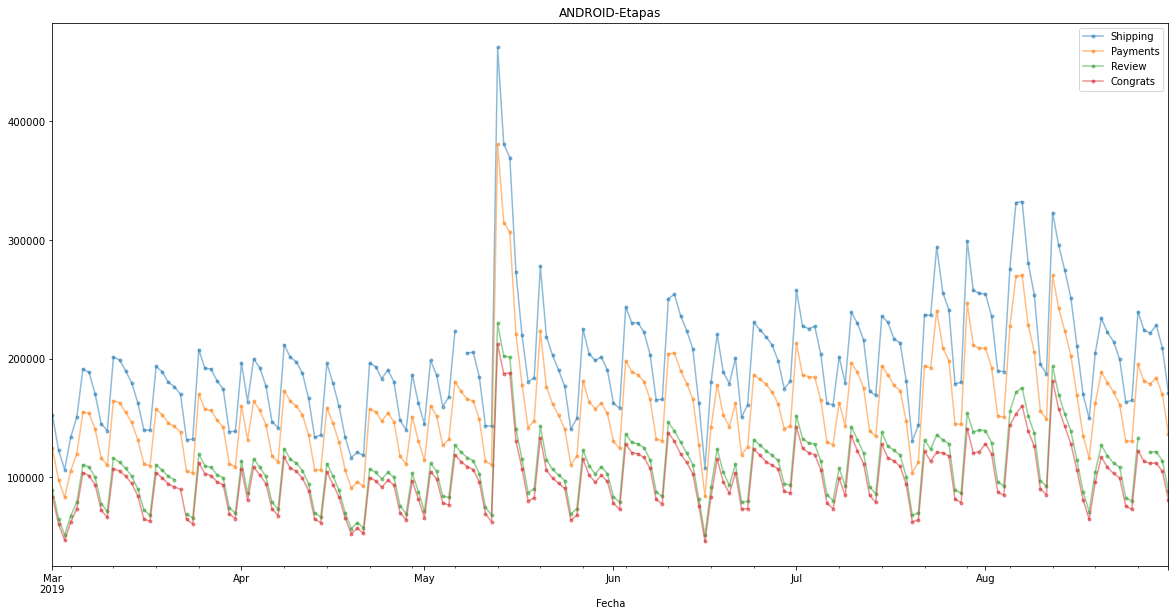

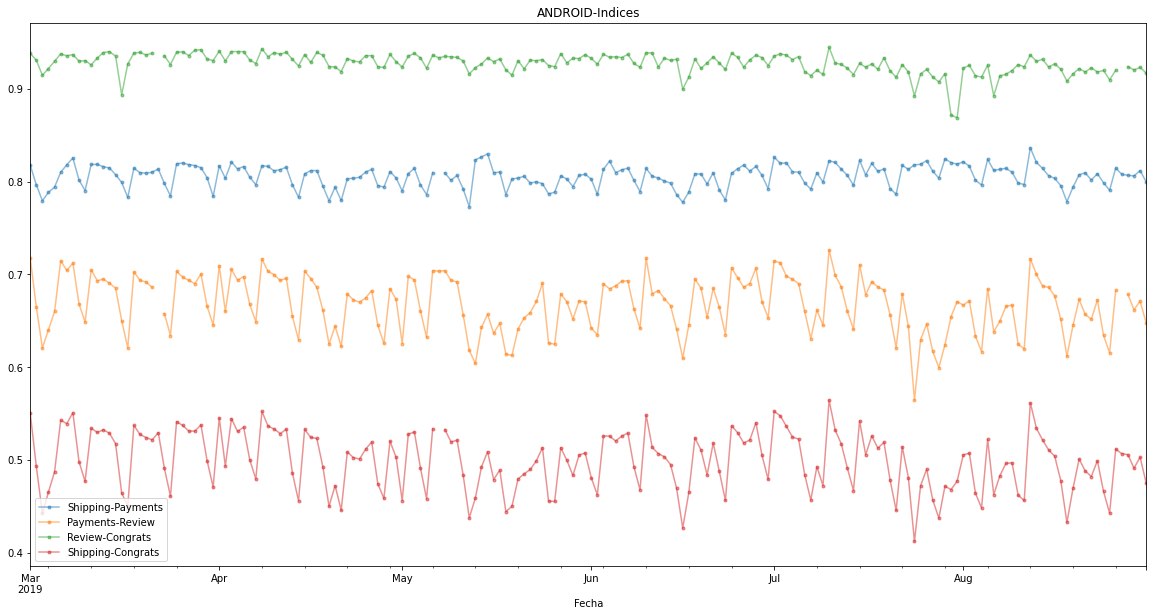

In [62]:
df_traffic_android['2019-03':'2019-08'][cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all",figsize=(20, 10)).set_title("ANDROID-Etapas")
df_traffic_android['2019-03':'2019-08'][cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID-Indices")

Text(0.5, 1.0, 'ANDROID INTERP-Indices')

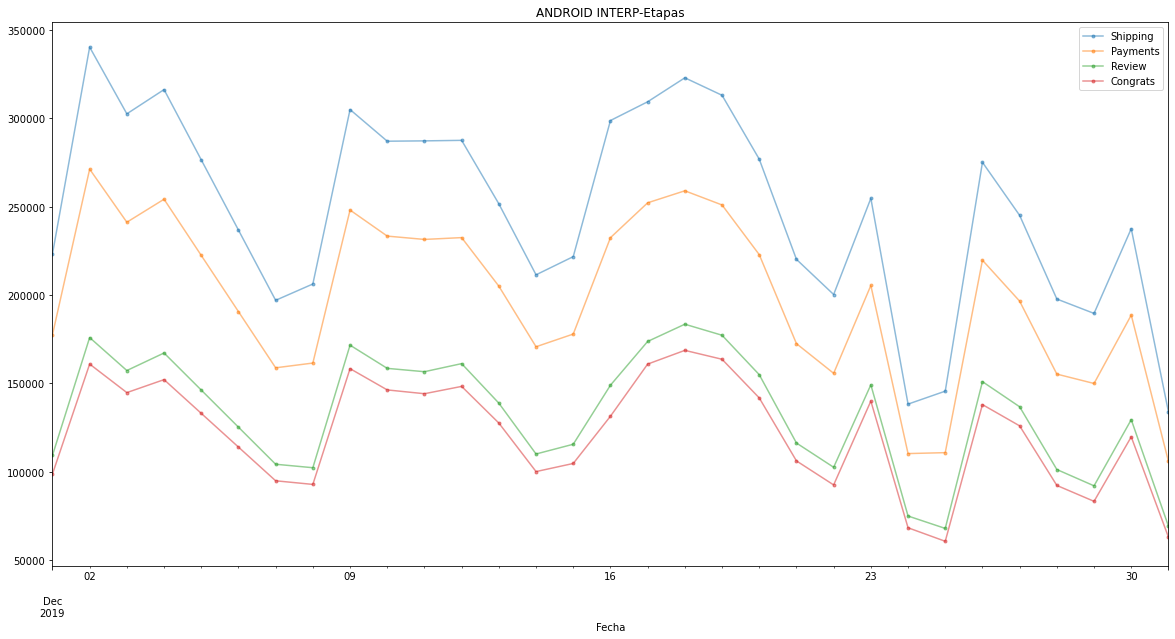

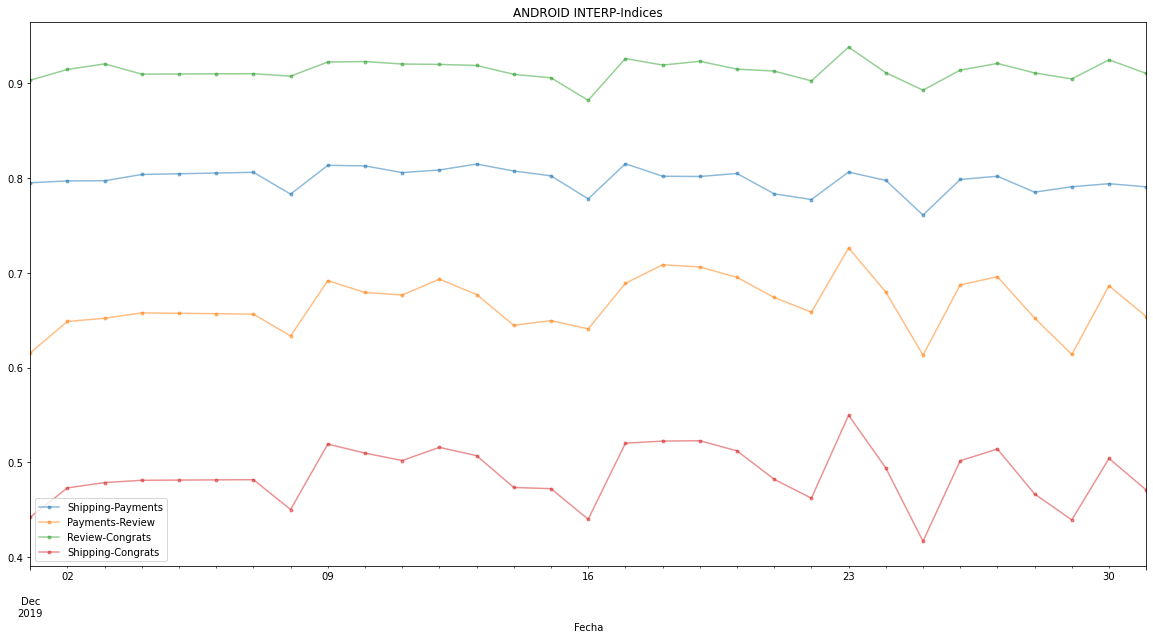

In [111]:
traffic_data_A_int['2019-12'][cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID INTERP-Etapas")
traffic_data_A_int['2019-12'][cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID INTERP-Indices")

In [52]:
#traffic_data_A_intC = df_traffic_android.interpolate(method='cubic')
#traffic_data_A_intC[traffic_data_A_intC['Payments']==172472]

In [53]:
#traffic_data_A_intP = df_traffic_android.interpolate(method='polynomial', order=3 )
#traffic_data_A_intP[traffic_data_A_intP['Payments']==172472]

Tanto la interpolación cúbica como la polinomial de 3er orden fueron descartadas dado que los valores imputados no eran lógicos. 

In [82]:
#convertimos los ceros a nan
df_traffic = df_traffic.replace(['0', 0], np.nan)

In [83]:
#interpolamos el data set completo de android y desktop
df_traffic_int=df_traffic.interpolate()

In [89]:
#recalculamos las tasas de conversión entre las diferentes etapas de compra luego de haber interpolado
df_traffic_int["Shipping-Payments"] = df_traffic_int["Payments"] / df_traffic_int["Shipping"]
df_traffic_int["Payments-Review"] = df_traffic_int["Review"] / df_traffic_int["Payments"]
df_traffic_int["Review-Congrats"] = df_traffic_int["Congrats"] / df_traffic_int["Review"]
df_traffic_int["Shipping-Congrats"] = df_traffic_int["Congrats"] / df_traffic_int["Shipping"]

In [90]:
cols_indices

['Shipping-Payments',
 'Payments-Review',
 'Review-Congrats',
 'Shipping-Congrats']

In [91]:
cols_indices_log=['Shipping-Payments(log)',
 'Payments-Review(log)',
 'Review-Congrats(log)',
 'Shipping-Congrats(log)']
cols_indices_log

['Shipping-Payments(log)',
 'Payments-Review(log)',
 'Review-Congrats(log)',
 'Shipping-Congrats(log)']

In [98]:
df_traffic[cols_indices_log] = np.log(df_traffic[cols_indices])

In [97]:
df_traffic_int[cols_indices_log] = np.log(df_traffic_int[cols_indices])

In [93]:
df_traffic_int.head()

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Shipping-Payments(log),Payments-Review(log),Review-Congrats(log),Shipping-Congrats(log)
Fecha,,,,,,,,,,,,,,,,,,,,
2019-03-01,direct,MLA,Android,"160,081.00","152,310.00","124,551.00","89,380.00","83,856.00",Friday,March,2019,March-2019,0.82,0.72,0.94,0.55,-0.20,-0.33,-0.06,-0.60
2019-03-01,direct,MLA,Desktop,"98,263.00","93,506.00","80,994.00","63,941.00","62,256.00",Friday,March,2019,March-2019,0.87,0.79,0.97,0.67,-0.14,-0.24,-0.03,-0.41
2019-03-02,direct,MLA,Android,"130,042.00","122,965.00","97,941.00","65,134.00","60,631.00",Saturday,March,2019,March-2019,0.80,0.67,0.93,0.49,-0.23,-0.41,-0.07,-0.71
2019-03-02,direct,MLA,Desktop,"51,778.00","49,285.00","41,652.00","30,945.00","30,009.00",Saturday,March,2019,March-2019,0.85,0.74,0.97,0.61,-0.17,-0.30,-0.03,-0.50
2019-03-03,direct,MLA,Android,"113,526.00","106,599.00","83,077.00","51,557.00","47,156.00",Sunday,March,2019,March-2019,0.78,0.62,0.91,0.44,-0.25,-0.48,-0.09,-0.82


In [112]:
# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic_int_desktop = df_traffic_int[df_traffic_int.Device==("Desktop")]
df_traffic_int_android = df_traffic_int[df_traffic_int.Device==("Android")]

Text(0.5, 1.0, 'ANDROID interpolada indices log')

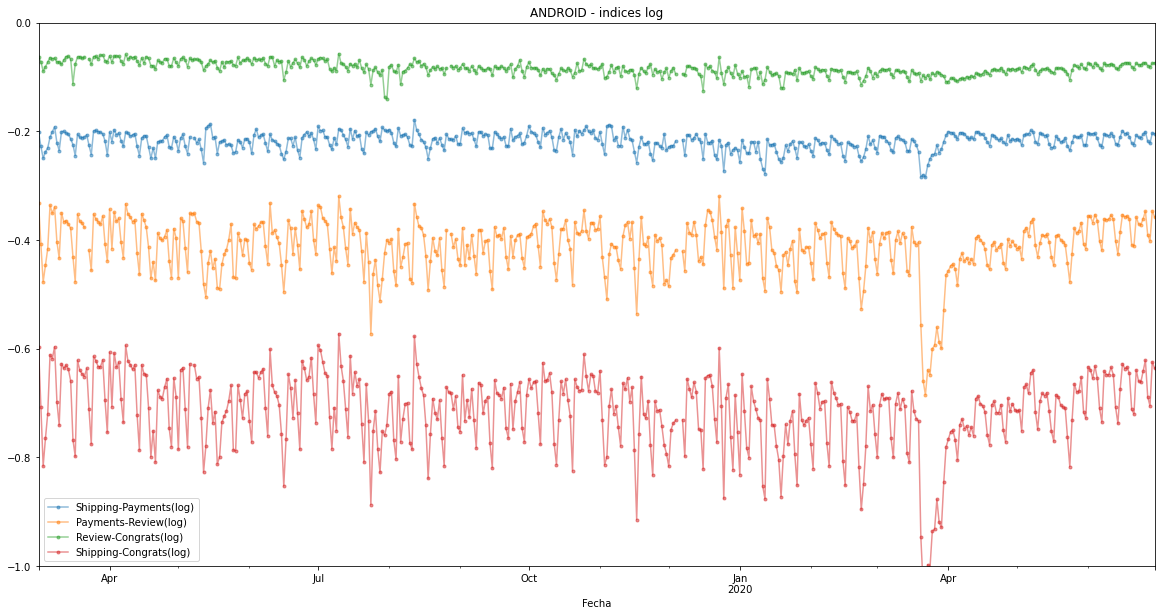

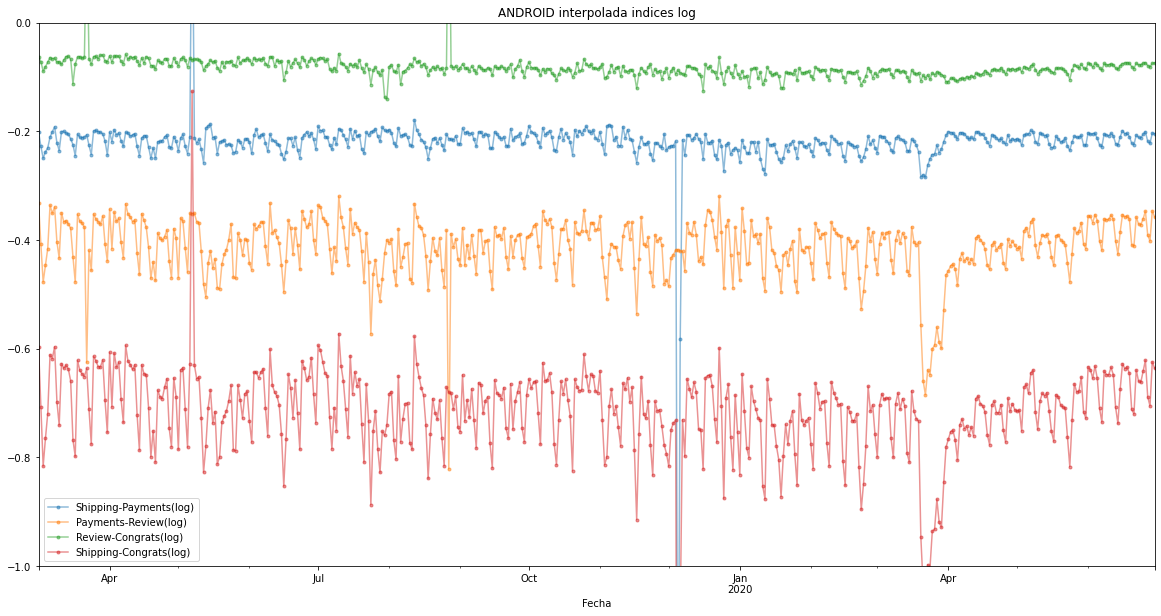

In [110]:
df_traffic[df_traffic_int["Device"]=="Android"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10), ylim=[-1,0]).set_title("ANDROID - indices log")
df_traffic_int[df_traffic_int["Device"]=="Android"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10),).set_title("ANDROID interpolada indices log")

Text(0.5, 1.0, 'DESKTOP interpolada indices log')

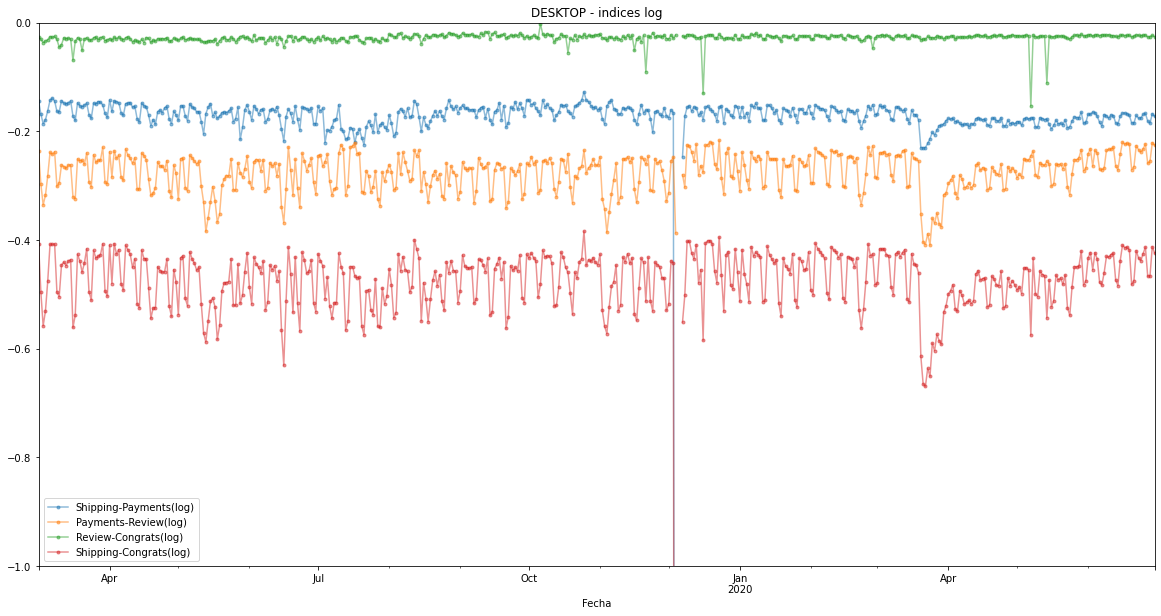

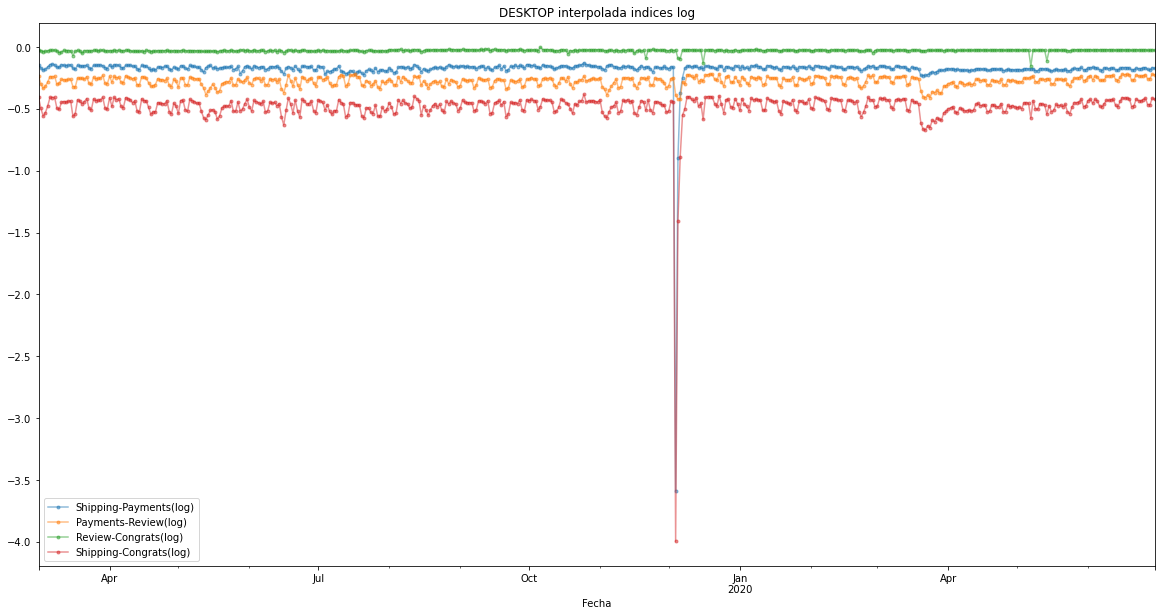

In [113]:
df_traffic[df_traffic_int["Device"]=="Desktop"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10), ylim=[-1,0]).set_title("DESKTOP - indices log")
df_traffic_int[df_traffic_int["Device"]=="Desktop"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10),).set_title("DESKTOP interpolada indices log")

In [103]:
df_traffic[cols_indices_log].describe()

,Shipping-Payments(log),Payments-Review(log),Review-Congrats(log),Shipping-Congrats(log)
count,971.00,970.00,970.00,971.00
mean,-0.20,-0.34,-0.06,-0.60
std,0.11,0.08,0.03,0.17
min,-3.59,-0.68,-0.15,-4.00
25%,-0.22,-0.40,-0.08,-0.71
50%,-0.20,-0.35,-0.06,-0.60
75%,-0.17,-0.27,-0.03,-0.46
max,-0.13,-0.22,-0.00,-0.38


In [104]:
df_traffic_int[cols_indices_log].describe()

,Shipping-Payments(log),Payments-Review(log),Review-Congrats(log),Shipping-Congrats(log)
count,976.00,976.00,976.00,976.00
mean,-0.20,-0.34,-0.06,-0.60
std,0.12,0.08,0.03,0.18
min,-3.59,-0.82,-0.15,-4.00
25%,-0.22,-0.40,-0.08,-0.71
50%,-0.20,-0.35,-0.06,-0.60
75%,-0.17,-0.27,-0.03,-0.46
max,0.29,-0.22,0.35,-0.13
